# RCM city detection

Looking for urban effects in RCM simulations

In [1]:
from pyesgf.logon import LogonManager
from pyesgf.search import SearchConnection
import dask
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import xarray as xr

In [11]:
var = 'tasmin' # 'rlus'
rcm = 'ALADIN63'
city = 'Paris'
location = dict(
      Madrid = dict(lon= -3.70, lat=40.42),
         NYC = dict(lon=-73.96, lat=40.73),
       Paris = dict(lon=  2.35, lat=48.85),
  Washington = dict(lon=-77.00, lat=38.90)
)
domain = dict(
      Madrid = 'EUR-11',
         NYC = 'NAM-22',
       Paris = 'EUR-11',
  Washington = 'NAM-22'
)
dlon = 20
dlat = 20
os.environ["ESGF_PYCLIENT_NO_FACETS_STAR_WARNING"] = "1"
os.environ["MESA_LOADER_DRIVER_OVERRIDE"]="i965"
# Deal with non-standard names...
rlat_names = {'rlat', 'y'}
rlon_names = {'rlon', 'x'}
rotated_pole_names = {'rotated_pole', 'rotated_latitude_longitude', 'Lambert_Conformal'}

vardic = dict(
  project='CORDEX',
  experiment=['evaluation',],
  rcm_name = rcm,
  domain = domain[city],
  variable=[var,],
  time_frequency = 'day',
  facets = 'dataset_id'
)

def select_name(names, avail_names):
  return(list(names.intersection(list(avail_names)))[0])
    
def ESGF_login():
  lm = LogonManager()
  lm.logoff()
  with open("openid.json") as fp:
    lm.logon_with_openid(**json.load(fp))
  if lm.is_logged_on():
    print("You are logged in!")
  else:
    print("/!\ There was some problem logging in")

def index_argmax(ds):
  rlon_name = select_name(rlon_names, ds.coords)
  rlat_name = select_name(rlat_names, ds.coords)
  rval = (
    ds[var]
      .isel(time = (
        ds[var]
           .isel(**{rlon_name: dlon, rlat_name: dlat})
           .argmax(dim='time')
           .values
        )
      )
  )
  rval = rval - rval.isel(**{rlon_name: dlon, rlat_name: dlat}).values
  return(rval)

def index_quantile(ds):
  return(
    (ds - ds.mean(dim=['rlon','rlat']))[var]
  #  (ds[var] - ds[var].isel(rlon=5,rlat=4).drop(['rlon', 'rlat','lon','lat',]))
      .groupby('time.season')
      .quantile(0.95, 'time')
      .sel(season='JJA')
  )

compute_index = index_argmax

In [3]:
%%time

nodeURL = 'http://esgf-data.dkrz.de/esg-search'
conn = SearchConnection(nodeURL, distrib=True)
ctx = conn.new_context(**vardic)
results = ctx.search(batch_size=200)
dids = [result.dataset_id for result in results]
ires = 0
files = results[ires].file_context().search()
opendap_urls = [file.opendap_url for file in files]

opendap_urls

CPU times: user 16.1 ms, sys: 11 ms, total: 27.1 ms
Wall time: 2.61 s


['http://esg1.umr-cnrm.fr/thredds/dodsC/CORDEX_CNRM/output/EUR-11/CNRM/ECMWF-ERAINT/evaluation/r1i1p1/CNRM-ALADIN63/v1/day/tasmin/v20191118/tasmin_EUR-11_ECMWF-ERAINT_evaluation_r1i1p1_CNRM-ALADIN63_v1_day_19790101-19801231.nc',
 'http://esg1.umr-cnrm.fr/thredds/dodsC/CORDEX_CNRM/output/EUR-11/CNRM/ECMWF-ERAINT/evaluation/r1i1p1/CNRM-ALADIN63/v1/day/tasmin/v20191118/tasmin_EUR-11_ECMWF-ERAINT_evaluation_r1i1p1_CNRM-ALADIN63_v1_day_19810101-19851231.nc',
 'http://esg1.umr-cnrm.fr/thredds/dodsC/CORDEX_CNRM/output/EUR-11/CNRM/ECMWF-ERAINT/evaluation/r1i1p1/CNRM-ALADIN63/v1/day/tasmin/v20191118/tasmin_EUR-11_ECMWF-ERAINT_evaluation_r1i1p1_CNRM-ALADIN63_v1_day_19860101-19901231.nc',
 'http://esg1.umr-cnrm.fr/thredds/dodsC/CORDEX_CNRM/output/EUR-11/CNRM/ECMWF-ERAINT/evaluation/r1i1p1/CNRM-ALADIN63/v1/day/tasmin/v20191118/tasmin_EUR-11_ECMWF-ERAINT_evaluation_r1i1p1_CNRM-ALADIN63_v1_day_19910101-19951231.nc',
 'http://esg1.umr-cnrm.fr/thredds/dodsC/CORDEX_CNRM/output/EUR-11/CNRM/ECMWF-ERAINT/

Crop the area around the city and persist the data on a NetCDF file. We need to log in to ESGF to actually retrieve data.

In [ ]:
%%time

fname = os.path.basename(opendap_urls[0])[:-21] + f'_{city}.nc'
if not os.path.exists(fname):
  ESGF_login()
  ds = xr.open_mfdataset(opendap_urls,
    parallel=True, chunks={'time':100},
    combine='nested', concat_dim='time',
    drop_variables = ['time_bnds']
  )
  #ds.isel(time=0).to_netcdf('test.nc')
  #
  #  Crop area around the city
  #
  dist = (ds['lon']-location[city]['lon'])**2 + (ds['lat']-location[city]['lat'])**2
  [ilat], [ilon] = np.where(dist == np.min(dist))
  ds_city = ds.isel(**{
    select_name(rlat_names, ds.coords): slice(ilat-dlat,ilat+dlat),
    select_name(rlon_names, ds.coords): slice(ilon-dlon,ilon+dlon)
  })
  #ds_city = ds.isel(y=slice(ilat-dlat,ilat+dlat), x=slice(ilon-dlon,ilon+dlon))
  ds_city.to_netcdf(fname, encoding = { var: {"zlib": True, "complevel": 9} })

## Plot index

In [ ]:
ds_city = xr.open_dataset(fname)
index = compute_index(ds_city)

Plot projected on native coordinates

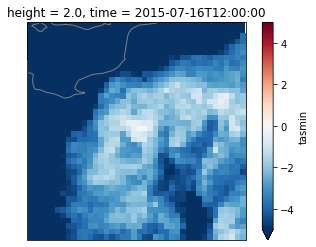

In [13]:
import cartopy.crs as ccrs
lonlat = ccrs.PlateCarree()
projvar = select_name(rotated_pole_names, ds_city.data_vars)
if projvar.startswith('rotated'):
  proj = ccrs.RotatedPole(
    pole_longitude=ds_city[projvar].grid_north_pole_longitude,
    pole_latitude=ds_city[projvar].grid_north_pole_latitude
  )
else:
  proj = ccrs.LambertConformal(
    central_longitude=ds_city[projvar].longitude_of_central_meridian,
    central_latitude=ds_city[projvar].latitude_of_projection_origin,
    secant_latitudes=None,
    standard_parallels=[ds_city[projvar].standard_parallel]
  )
f = plt.figure()
ax = plt.axes(projection=proj)
index.plot.pcolormesh(
  #ax=ax, x='lon', y='lat', transform=lonlat, cmap=plt.cm.YlOrBr#, vmax=10
  ax=ax, x='lon', y='lat', transform=lonlat, cmap=plt.cm.RdBu_r, vmax=5
)
ax.coastlines(resolution='50m', linewidth=1, color='gray')
plt.savefig(fname.replace('nc','png'), facecolor='white')
plt.show()
plt.close('all')